采用支持向量机(svm)学习算法建立预测模型。

支持向量机是最流行的分类算法之一，它有一种优雅的方式来转换非线性数据，
这样人们就可以使用线性算法来拟合数据的线性模型(Cortes和Vapnik 1995)。
核支持向量机是一种功能强大的模型，在各种数据集上都表现良好。
1.支持向量机允许复杂的决策边界，即使数据只有几个特征。
2.它们可以很好地处理低维和高维数据(即，特征少和特征多)，但不能很好地处理样本数量。
在包含多达10,000个样本的数据上运行SVM可能工作得很好，但是在运行时和内存使用方面，
处理100,000或更多的数据集可能会变得具有挑战性。
3. 支持向量机需要仔细的数据预处理和参数调优。这就是为什么，这些天，大多数人在许多应用中使用基于树的模型，如随机森林或梯度增强(这需要很少或不需要预处理)。
4.支持向量机模型难以检验;很难理解为什么会做出一个特定的预测，而且向非专家解释这个模型可能会很棘手。

4.1重要的参数

核支持向量机的重要参数是
1.正则化参数C
2.核的选择，(线性，径向基函数(RBF)或多项式)
3.核的特定参数。
gamma和C都控制着模型的复杂性，其中任何一个的大值都会导致更复杂的模型。
因此，这两个参数的良好设置通常是强相关的，C和gamma应该一起调整。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#加载库进行数据处理
import pandas as pd
import numpy as np
from scipy.stats import norm

#监督学习
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

#可视化
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (10,8) 
data = pd.read_csv('data/data.csv')
#数据预处理
X = data.iloc[:,2:32] # 特征
y = data.iloc[:,1] # 标签
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
y = le.fit_transform(y)

#规范化数据(以0为中心并缩放以消除方差)。
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

4.2交叉验证分类

正如在Notebook预处理与特征工程中所讨论的那样，将数据分成测试集和训练集对于避免过拟合至关重要。
这允许对真实的、以前看不见的数据进行泛化。交叉验证进一步扩展了这个想法。
我们没有使用单一的训练/测试分割，而是指定了所谓的折叠，以便将数据划分为大小相似的折叠。
1.训练是通过取除一个以外的所有折叠来进行的，这个折叠被称为保留样本。
2.在训练完成后，使用保留样本测试拟合模型的性能。
然后，将夹住样品与其余的其他褶皱一起扔回，并将另一个褶皱拉出作为新的夹住样品。
3.对剩余的折叠再次重复训练，我们使用保留样本来衡量性能。
4.重复这个过程，直到每个折叠都有机会成为测试或保留样本。
5.分类器的预期性能，称为交叉验证误差，然后简单地计算每个保留样本上的错误率的平均值。
这个过程是通过首先执行一个标准的训练/测试分割，然后计算交叉验证误差来演示的。

In [2]:
#在训练集和测试集中划分记录。
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=33, stratify=y)

#创建一个SVM分类器并在70%的数据集上训练它。
clf = SVC(probability=True)
clf.fit(X_train, y_train)

#分析30%的拒绝测试样本的预测准确性。
classifier_score = clf.score(X_test, y_test)*100
print('\n分类器的准确率得分为{:03.2f}%\n'.format(classifier_score))


分类器的准确率得分为96.49%



为了更好地测量预测精度(你可以用它作为模型的“拟合优度”的代理)，可以连续地将数据分成折叠，将用于训练和测试:

In [3]:
#使用SVC估计器获得3倍交叉验证分数的平均值。
n_folds = 5
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))*100
print('\n该分类器的{}-fold交叉验证准确率得分为 {:.2f}%\n'.format(n_folds, cv_error))


该分类器的5-fold交叉验证准确率得分为 97.36%



上述评估是基于使用整个特征集。
现在，我将采用基于相关性的特征选择策略来评估使用与类标签具有最佳相关性的3个特征的效果。

In [4]:
from sklearn.feature_selection import SelectKBest, f_regression
clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))

scores = cross_val_score(clf2, Xs, y, cv=3)

#使用SVC估计器获得3倍交叉验证分数的平均值。
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))*100
print('\n该分类器的{}-fold交叉验证准确率得分为{:.2f}%\n'.format(n_folds, cv_error))


该分类器的3-fold交叉验证准确率得分为97.36%



In [5]:
print(scores)
avg = (100*np.mean(scores), 100*np.std(scores)/np.sqrt(scores.shape[0]))
print("平均分和不确定性: (%.2f +- %.3f)%%"%avg)

[0.93157895 0.95263158 0.94179894]
平均分和不确定性: (94.20 +- 0.496)%


从上面的结果中，可以看到，只需要一小部分特征就可以构建一个与使用整个特征集的模型执行类似的模型。
特征选择是模型构建过程的一个重要部分，必须始终特别注意细节。
在接下来的分析中，您将继续使用整个特性集。

4.3模型精度:受试者工作特征(ROC)曲线

在统计建模和机器学习中，通常报道的二分类问题模型精度的性能度量是曲线下面积(AUC)。
为了理解ROC曲线所传达的信息，考虑一下所谓的混淆矩阵，它本质上是一个二维表格，
其中分类器模型在一个轴上(垂直)，而基本事实在另一个轴上(水平)，
如下所示。这些轴中的任何一个都可以取两个值(如下所示)
模型显示:“+”|模型显示“-”--- | --- | ---真阳性|假阴性
实际:“+”假阳性|真阴性
实际:“-”在ROC曲线中，您在y轴上绘制“真阳性率”，在x轴上绘制“假阳性率”，
其中值“真阳性”、“假阴性”、“假阳性”和“真阴性”是如上所述的事件(或其概率)。费率的定义如下:
1.真阳性率(或敏感性):tpr tp/ (tp +fn)
2.假阳性率:fpr = fp/ (fp + tn)
3.真阴性率(或特异性):tnr tn/ (fp tn)
在所有定义中，分母是上述混淆矩阵中的行边距。
因此，我们可以将真阳性率(tpr)表示为当真实值确实是“+”时模型说“+”的概率(即条件概率)。
但是，这并不能告诉您调用“+”时正确的可能性有多大(即，以测试结果为“+”为条件的真阳性概率)。

In [6]:
#混淆矩阵有助于可视化算法的性能。
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[107   0]
 [  6  58]]


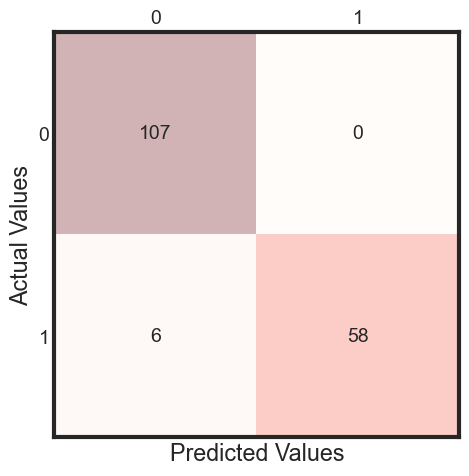

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred ))

观察：有两种可能的预测类别:“1”和“0”。恶性1(表示存在癌细胞)，良性0(表示脓肿)。
1.分类器总共做出174项预测(即174名患者正在接受乳腺癌检测)。
2.在这174个案例中，分类器预测了58次“是”，113次“否”。
3.实际上，样本中有64名患者患有这种疾病，107名患者没有。

由混淆矩阵计算出的速率。
1.准确率:总的来说，分类器的正确率是多少?
(TP+TN)/total =(57+106)/171 = 0.952。
2.错误分类率:总的来说，有多少次是错误的?
(FP+FN)/total =(1+7)/171 = 0.05，相当于1减去准确率也称为“错误率”。
3.真阳性率:当它实际上是肯定的时候，它预测1的频率是多少?
TP/actual yes = 57/64 = 0.89也称为“灵敏度”或“召回”。
4.误报率:当它实际上是0时，它预测1的频率是多少?
FP/actual no = 1/107 = 0.01。
5.特异性:当它实际上是O时，它预测O的频率是多少?也称为真阳性率
/actual no = 106/107 = 0.99，等于1减去假阳性率。
6.精度:当它预测1时，有多少次是正确的?
TP/预测值是= 57/58 = 0.98。
7.患病率:“是”情况在我们的样本中实际发生的频率是多少?
actual yes/total = 64/171 = 0.34

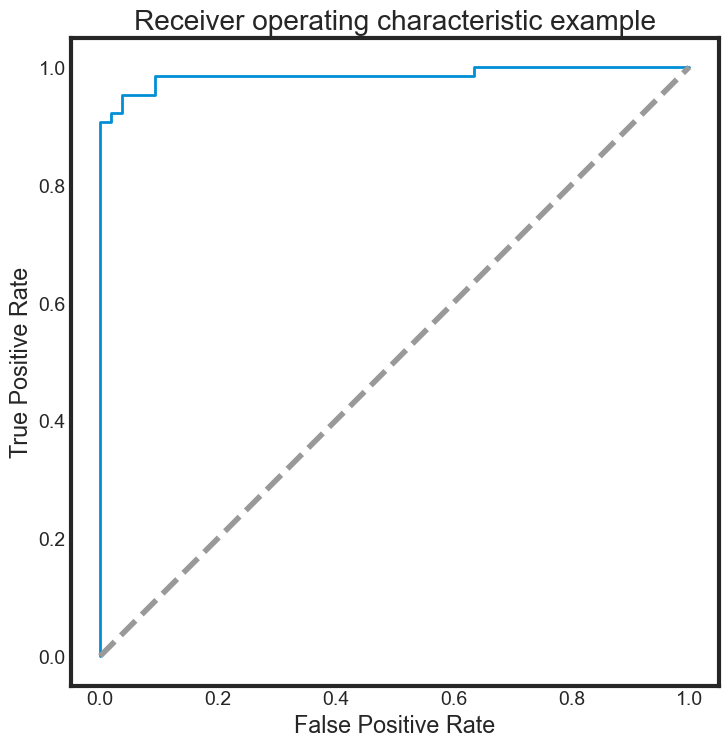

In [8]:
def ROC_plot(y, yproba):
    from sklearn.metrics import roc_curve, auc
    plt.figure(figsize=(10,8))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC fold (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.gca().set_aspect('equal', adjustable='box')

probas_ = clf.predict_proba(X_test)
ROC_plot(y, probas_[:1])


为了正确地解释ROC，考虑沿对角线的点代表什么。
在这些情况下，出现“+”和“-”的几率是相等的。
因此，这与通过投掷无偏硬币进行预测并没有什么不同。
简单地说，分类模型是随机的。对于对角线上方的点，tpr > fpr，模型表明你处于一个比随机表现更好的区域。
例如，假设tpr = 0.99, fpr = 0.01，则处于真阳性组的概率为(0.99/(0.99 + 0.01))= 99%。
此外，保持fpr不变，很容易看出，您的位置越垂直于对角线上方，分类模型就越好。
接下来我将研究如何优化类